In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [159]:
from itertools import chain, compress
from cge_modeling.base.utilities import variable_dict_to_flat_array

In [184]:
df = pd.read_csv("data/cge10_sam.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
# assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df.sum(axis=0) - df.sum(axis=1)

Factor       Labor                   0.0
             Capital                 0.0
             Coal                    0.0
             Nuclear                 0.0
Institution  Household               0.0
             Firms                   0.0
             Govt                    0.0
Production   Agriculture             0.0
             Industry                0.0
             Services                0.0
             Utility                 0.0
             Coal                    0.0
             Nuclear                 0.0
Activities   Agriculture             0.0
             Industry                0.0
             Services                0.0
             Utility                 0.0
             Coal                    0.0
             Nuclear                 0.0
Other        Capital Accumulation    0.0
dtype: float64

In [254]:
sectors = ["Ag", "Ind", "Serv", "Uty"]
eprod = ["coal", "nuc"] # ,"sol"]
n_sectors = len(sectors)
n_eprod = len(eprod)
coords = {"i": sectors, "j": sectors, "k": eprod}

In [370]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    
    Variable(name="X", dims=("i", "j"),
             description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",),
    
    # Captial Labour bundle
    Variable(name="L_S_d", dims="i", extend_subscript=True, description="Labor demand in the <dim:i> sector",),
    Variable(name="L_E_d", dims="k", extend_subscript=True, description="Labor demand in the <dim:k> e-sector",),
    Variable(name="K_S_d", dims="i", extend_subscript=True, description="Capital demand in the <dim:i> sector",),
    Variable(name="K_E_d", dims="k", extend_subscript=True, description="Capital demand in the <dim:k> e-sector",),
    
    Variable(name="KL_S_d", dims="i", extend_subscript=True, description="Labor Capital demand in the <dim:i> sector",),
    Variable(name="KL_E_d", dims="k", extend_subscript=True, description="Labor Capital demand in the <dim:k> e-sector",),
    
    # Raw energy producer
    Variable(name="W_d", dims="k", extend_subscript=True, description="Raw energy demand of <dim:k> sector",),
    Variable(name="R_d", dims="k", extend_subscript=True, description="Ressource demand of <dim:k> sector",),
    
    Variable(name="E_d", dims="i", extend_subscript=True, description="Energy demand in the <dim:i> sector",),
    Variable(name="E_s", description="Energy supply from energy bundler",),
    
    # Investment
    
    Variable( name="I_d", dims="i", extend_subscript=True, description="Investment capital demanded by the <dim:i> sector",),
    
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(name="P_Y", dims="i", extend_subscript=True, 
             description="Final good price in the <dim:i> sector, before taxes",),
    
    Variable(name="P_VA", dims="i", extend_subscript=True,
             description="Price of the value-add component in the <dim:i> sector",),
    Variable(name="P_VC", dims="i", extend_subscript=True, 
             description="Price of the value-chain component in the <dim:i> sector",),
    
    Variable(name="P_KL_S", dims="i", extend_subscript=True, 
             description="Capital labour bundle price in the <dim:i> sector",),
    Variable(name="P_KL_E", dims="k", extend_subscript=True, 
             description="Capital labour bundle price in the <dim:k> sector",),
    
    
    Variable(name="P_E", extend_subscript=True, description="Electricity price",),
    Variable(name="P_W", dims="k", extend_subscript=True, description="Raw energy price",),
    Variable(name="P_R", dims="k", extend_subscript=True, description="Ressource energy price",),
    
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),

    # Household Variables
    Variable(name="U", description="Household utility"),
    
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    
    Variable(name="I_s", extend_subscript=True, description="Investment capital supplied by households"),
    Variable(name="S", description="Household savings"),
    
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"),

    # Government variables
    Variable(name="G", description="Government budget"),
    Variable(name="C_G", dims="i", extend_subscript=True, description="Government consumption of <dim:i> goods",),
    Variable(name="S_G", extend_subscript=True, positive=None, description="Investment capital supplied by government",),
    
    # Misc
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
    
]

param_info = [
    
    # Production Parameters
    Parameter("alpha_VA", dims="i", description="Share of capital in production of the <dim:i> sector value-add bundle",),
    Parameter("alpha_KL_S", dims="i", 
              description="Share of capital in production of the <dim:i> producer capital labour bundle",),
    Parameter("alpha_KL_E", dims="k", 
              description="Share of capital in production of the <dim:k> producer capital labour bundle",),  
    Parameter("alpha_W", dims="k", 
              description="Share of capital in production of the <dim:k> producer capital labour bundle",),  
    
    Parameter("alpha_k", dims="i", extend_subscript=True,
              description="Share of capital investment demanded by the <dim:i> sector",),
    
    # Technology parameters
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter("A_W", dims="k", description="Total factor productivity of the <dim:k> sector"),
    
    Parameter("A_KL_S", dims="i", description="Captial Labour factor productivity of <dim:i> producer"),
    Parameter("A_KL_E", dims="k", description="Captial Labour factor productivity of <dim:k> producer"),
    
    # Leontief shares
    Parameter("psi_VA", extend_subscript=True, dims="i",
              description="Share of value-add bundle in <dim:i> sector final good production",),
    Parameter("psi_VC", extend_subscript=True, dims="i",
              description="Share of value chain bundle in <dim:i> sector final good production",),
    Parameter("psi_X", extend_subscript=True, dims=("i", "j"), 
              description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",),
    Parameter("psi_W", extend_subscript=True, dims="k", description="Share of <dim:k> raw energy in electricity"),
    
    # CES elasticities
    Parameter(name="epsilon_VA",extend_subscript=True, dims="i", 
              description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",),
    Parameter(name="epsilon_W", extend_subscript=True, dims="k", 
              description="Elasticity of subsitution between input factors in <dim:k> sector W",),
    
    Parameter(name="epsilon_KL_S", extend_subscript=True, dims="i", 
              description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",),
    Parameter(name="epsilon_KL_E", extend_subscript=True, dims="k", 
              description="Elasticity of subsitution between input factors in <dim:k> producer KL bundle",),
    
    # Tax parameters
    Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    
    # Household parameters
    Parameter("gamma", dims="i", description="Household elasticity of consumption utility for <dim:i> sector goods",),
    Parameter("mps", latex_name="phi", description="Household marginal propensity to save"),
    
    # Government parameters
    Parameter("alpha_G", dims="i", description="Share of <dim:i> sector final goods in governmnet consumption",),
    
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("R_s", dims="k", description="Exogenous raw energy endowment"),
    
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
    Parameter("S_G_bar", latex_name=r"\\bar{S}_G", description="Exogenous level of governmnet savings", positive=None,),
]

equations = [
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for value added", "VA = psi_VA * Y"),
    
    # Value chain bundle
    Equation("Sector <dim:i> production of intermediate goods bundle", 
             "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), " + f"(j, 0, {n_sectors - 1}))"),

    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC.subs({i:j})",),
    
    # Value add bundle
    Equation("Sector <dim:i> production of value add",
             "VA = A_VA * (alpha_VA * KL_S_d**((epsilon_VA - 1) / epsilon_VA) +"
             "(1 - alpha_VA) * E_d**((epsilon_VA - 1) / epsilon_VA)) ** (epsilon_VA / (epsilon_VA - 1))",
    ),
    Equation("Sector <dim:i> demand for capital labour bundle", 
             "KL_S_d = VA / A_VA * (alpha_VA * P_VA * A_VA / P_KL_S) ** epsilon_VA"
    ),
    Equation("Sector <dim:i> demand for energy",
             "E_d = VA / A_VA * ((1 - alpha_VA) * A_VA * P_VA / P_E) ** epsilon_VA",
    ),
    
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital and labour",
             "KL_S_d = A_KL_S * (alpha_KL_S * K_S_d ** ((epsilon_KL_S - 1) / epsilon_KL_S) +"
             "(1 - alpha_KL_S) * L_S_d **((epsilon_KL_S - 1) / epsilon_KL_S)) ** (epsilon_KL_S / (epsilon_KL_S - 1))",
    ),
    Equation("Producer <dim:i> demand for captial",
             "K_S_d = KL_S_d / A_KL_S * (alpha_KL_S * P_KL_S / r * A_KL_S) ** epsilon_KL_S",
    ),
    Equation("Producer <dim:i> demand for labour",
             "L_S_d = KL_S_d / A_KL_S * ((1 - alpha_KL_S) * P_KL_S / w * A_KL_S) ** epsilon_KL_S"
    ),
        
    # Energy types
    Equation("Energy producer <dim:k> production",
             "W_d = A_W * (alpha_W * KL_E_d**((epsilon_W - 1) / epsilon_W) +"
             "(1 - alpha_W) * R_d**((epsilon_W - 1) / epsilon_W)) ** (epsilon_W / (epsilon_W - 1))",
    ),
    Equation("Sector <dim:k> demand for capital labour bundle", 
             "KL_E_d = W_d / A_W * (alpha_W * P_W * A_W / P_KL_E) ** epsilon_W"
    ),
    Equation("Sector <dim:k> demand for raw energy",
             "R_d = W_d / A_W * ((1 - alpha_W) * A_W * P_W / P_R) ** epsilon_W",
    ),
    
    # Capital Labour aggregation
    Equation("Producer <dim:k> production of capital and labour",
             "KL_E_d = A_KL_E * (alpha_KL_E * K_E_d ** ((epsilon_KL_E - 1) / epsilon_KL_E) +"
             "(1 - alpha_KL_E) * L_E_d **((epsilon_KL_E - 1) / epsilon_KL_E)) ** (epsilon_KL_E / (epsilon_KL_E - 1))",
    ),
    Equation("Producer <dim:k> demand for captial",
             "K_E_d = KL_E_d / A_KL_E * (alpha_KL_E * P_KL_E / r * A_KL_E) ** epsilon_KL_E",
    ),
    Equation("Producer <dim:k> demand for labour",
             "L_E_d = KL_E_d / A_KL_E * ((1 - alpha_KL_E) * P_KL_E / w * A_KL_E) ** epsilon_KL_E"
    ),
    
    # Electricity aggregation
    Equation("Electricty production", "P_E * E_s = Sum(P_W * W_d, " + f"(k, 0, {n_eprod-1}))"),
    Equation("Demand of raw energy <dim:k>", "W_d = psi_W * E_s"),
    
    # Sector invest
    Equation("<dim:i> sector demand for investment capital", "P * I_d = alpha_k * I_s"),
        
    
    # Government block
    Equation("Government budget constraint", 
             "G + S_G = tau_income * income + Sum(tau * P_Y * Y, " + f"(i, 0, {n_sectors-1}))",),
    
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Sector <dim:i> after-tax price", "P = (1 + tau) * P_Y"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    
    # Household block
    Equation("Household pre-tax income", "income = w * L_s + r * K_s" +
             "+ Sum(R_s * P_R, " + f"(k, 0, {n_eprod-1}))"),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),

    Equation("Household utility", "U = Product(C**gamma, " + f"(i, 0, {n_sectors-1}))"),
    Equation("Household demand for good <dim:i>", "C * P = gamma * (1 - mps) * net_income"),
    Equation("Household savings", "S = mps * net_income"),
    
        
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    
    Equation("Labour market clearing", 
             "L_s = Sum(L_S_d, " + f"(i, 0, {n_sectors - 1}))" + " + Sum(L_E_d, " +f"(k, 0, {n_eprod-1}))"
            ),
    Equation("Capital market clearing", 
             "K_s = Sum(K_S_d, " + f"(i, 0, {n_sectors - 1}))" + " + Sum(K_E_d, " +f"(k, 0, {n_eprod-1}))"
            ),
    
    Equation("Energy market clearing", "E_s = Sum(E_d, " + f" (i, 0, {n_sectors - 1}))",),  
    
    Equation("Ressource energy market clearing <dim:k>", "R_s = R_d"),
    
    Equation("Sector <dim:i> goods market clearing", f"Y = C + C_G + I_d + Sum(X, " + f"(j, 0, {n_sectors - 1}))"),
    
    Equation("Numeraire", "P.subs({i:'Ag'}) = P_num"),
]

In [ ]:
mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
    backend="numba",
    # mode="JAX",
    compile=True,
)

In [ ]:
mod.n_variables

In [369]:
len(mod.unpacked_equation_names)

105

In [290]:
# for i in mod.unpacked_equations:
#     display(i)

In [291]:
def get_CES_params(fac1, fac2, p1, p2, output, epsilon):
    _rho = (epsilon - 1) / epsilon
    alpha = p1 * fac1 ** (1 / epsilon) / ((p1 * fac1 ** (1 / epsilon) + p2 * fac2 ** (1 / epsilon)))
    A = output * (alpha * fac1**_rho + (1 - alpha) * fac2**_rho) ** (-1 / _rho)
    return A, alpha

def get_DXS_params(P: np.array, X: np.array, epsilon: float):
    assert P.shape == X.shape, "Price and good shapes do not match"
    
    _rho = (epsilon - 1) / epsilon
    alpha = P * X ** (1 / epsilon) / (P * X ** (1 / epsilon)).sum()
    A = X.sum() * (alpha * X**_rho).sum() ** (-1 / _rho)
    return A, alpha

In [356]:
def calibrate_model(
    income_tax_revenue,
    sales_tax_revenue,
    S,
    S_G,
    L_S_d,
    K_S_d,
    L_E_d,
    K_E_d,
    E_d,
    R_d,
    C,
    C_G,
    Y,
    X,
    I_d,
    epsilon_VA,
    epsilon_KL_S,
    epsilon_KL_E,
    epsilon_W,
    variables,
    parameters,
):

    # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_E = 1.0
    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)
    P_KL_S = np.ones(n_sectors)
    
    P_KL_E = np.ones(n_eprod)
    P_W = np.ones(n_eprod)
    P_R = np.ones(n_eprod)

    # Zero the residual
    resid = 0.0

    # Factor supplies
    L_s = L_S_d.sum() + L_E_d.sum()
    K_s = K_S_d.sum() + K_E_d.sum()
    E_s = E_d.sum()
    
    R_s = R_d

    # Tax rates
    tau = sales_tax_revenue / (Y - sales_tax_revenue)
    P = P_Y * (1 + tau)

    # Numeraire
    P_num = P[0]

    X /= P[:, None]
    C /= P
    C_G /= P
    I_d /= P
    Y /= P

    # Firm calibration
    KL_S_d = (K_S_d * r + L_S_d * w) / P_KL_S
    KL_E_d = (K_E_d * r + L_E_d * w) / P_KL_E
    W_d = (KL_E_d * P_KL_E + R_d * P_R) / P_W
    VA = (P_KL_S * KL_S_d + P_E * E_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    A_VA, alpha_VA = get_CES_params(KL_S_d, E_d, P_KL_S, P_E, VA, epsilon_VA)
    A_KL_S, alpha_KL_S = get_CES_params(K_S_d, L_S_d, r, w, KL_S_d, epsilon_KL_S)
    A_KL_E, alpha_KL_E = get_CES_params(K_E_d, L_E_d, r, w, KL_E_d, epsilon_KL_E)
    A_W, alpha_W = get_CES_params(KL_E_d, R_d, P_KL_E, P_R, W_d, epsilon_KL_E)
    
#     A_C, alpha_C = get_DXS_params(P, C, epsilon_C)
#     C_total = (alpha_C * C ** ((epsilon_C - 1) / epsilon_C)).sum() ** (epsilon_C / (epsilon_C - 1))
#     U = C_total
    
    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]
    psi_W = W_d / E_s

    income = w * L_s + r * K_s + P_E * E_s
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    mps = S / net_income
    consumption_spend = (1 - mps) * net_income

    gamma = P * C / consumption_spend
    U = np.prod(C**gamma)
    
    # Exogenous government spending level
    S_G_bar = S_G

    G = (P * C_G).sum()
    alpha_G = (P * C_G) / G

    I_s = (P * I_d).sum()
    alpha_k = P * I_d / I_s

    d = {}
    for obj in variables + parameters:
        if obj.name != "_":
            d[obj.name] = locals()[obj.name]

    return d

In [358]:
sectors_pretty_name = list(df['Production'].columns[:n_sectors])
eprod_pretty_name = list(df['Production'].columns[n_sectors:])

In [359]:
initial_data = {
    "income_tax_revenue": df.loc[("Institution", "Govt"), ("Institution", "Household")],
    "sales_tax_revenue": df.loc[("Institution", "Govt"), "Production"].loc[sectors_pretty_name].values,
    "S": df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")],
    "S_G": df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")],
    "L_S_d": df.loc[("Factor", "Labor"), ("Activities", sectors_pretty_name)].values,
    "K_S_d": df.loc[("Factor", "Capital"), ("Activities", sectors_pretty_name)].values,
    "L_E_d": df.loc[("Factor", "Labor"), ("Activities", eprod_pretty_name)].values,
    "K_E_d": df.loc[("Factor", "Capital"), ("Activities", eprod_pretty_name)].values,
    "E_d": df.loc[("Production", "Utility"), ("Activities", sectors_pretty_name)].values,
    "R_d": df.loc[('Institution', 'Household'), ('Factor', eprod_pretty_name)].values,
    "I_d": df.loc[("Production", sectors_pretty_name), ("Other", "Capital Accumulation")].values,
    "C": df.loc[("Production", sectors_pretty_name), ("Institution", "Household")].values,
    "C_G": df.loc[("Production", sectors_pretty_name), ("Institution", "Govt")].values,
    "Y": df.loc[("Production")].loc[ sectors_pretty_name].sum(axis=1).values,
    "X": df.loc["Production", "Activities"].loc[sectors_pretty_name, sectors_pretty_name].values,
}

econometric_estimates = {
    "epsilon_VA": np.ones(n_sectors) * 10.0,
    "epsilon_KL_S": np.ones(n_sectors) * 10.0,
    "epsilon_KL_E": np.ones(n_eprod) * 10.0,
    "epsilon_W": np.ones(n_eprod) * 5.0,
                        }

In [362]:
calibrated_data['P_VC']

array([1., 1., 1., 1.])

In [339]:
calibrated_data = calibrate_model(
    **(initial_data | econometric_estimates), variables=mod.variables, parameters=mod.parameters
)

In [340]:
[i for i in [*chain(mod.variable_names, mod.parameter_names)] if i not in calibrated_data.keys()]

[]

In [341]:
[i for i in calibrated_data.keys() if i not in [*chain(mod.variable_names, mod.parameter_names)]]

[]

In [342]:
var_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.parameter_names]]

In [343]:
mod.f_resid(exog_inputs=var_inputs, endog_inputs=param_inputs)

array(19860000.)

In [344]:
resids = mod.f_system(var_inputs, param_inputs)
[*compress(mod.unpacked_equation_names, np.abs(resids) > 1e-8)]

['Final good production of sector Ag',
 'Final good production of sector Ind',
 'Final good production of sector Serv',
 'Final good production of sector Uty',
 'Electricty production',
 'Household pre-tax income']

In [77]:
[*compress(mod.unpacked_equation_names, abs(resids) > 1e-8)]

['Sector Ag demand for capital labour bundle',
 'Sector Ind demand for capital labour bundle',
 'Sector Serv demand for capital labour bundle',
 'Sector Ag demand for energy',
 'Sector Ind demand for energy',
 'Sector Serv demand for energy',
 'Sector Ag demand for captial',
 'Sector Ind demand for captial',
 'Sector Serv demand for captial',
 'Sector Ag demand for labour',
 'Sector Ind demand for labour',
 'Sector Serv demand for labour',
 'Household overall consumption',
 'Household Marshallian demands good Ag',
 'Household Marshallian demands good Ind',
 'Household Marshallian demands good Serv',
 'CPI equation']

In [45]:
param_dict = {k.name: calibrated_data[k.name] for k in mod.parameters}
var_dict = {k.name: calibrated_data[k.name] for k in mod.variables}

In [46]:
mod.generate_SAM(param_dict, var_dict) # method="minimize")


KeyboardInterrupt



## Policy Simulation -- Tax Cut

In [47]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array
from copy import deepcopy

tax_cut = deepcopy(calibrated_data)

# 50% income tax cut
tax_cut["tau_income"] *= 0.0
_, theta_tax_cut = variable_dict_to_flat_array(tax_cut, mod.variables, mod.parameters)

In [48]:
n_steps = 10_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_tax_cut, n_steps=n_steps
)

In [69]:
new_data = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]
mod.check_for_equilibrium(new_data)

TypeError: too many arguments: expected 2, got 39

In [50]:
from cge_modeling.base.utilities import flat_array_to_variable_dict

res = mod._solve_with_root(calibrated_data, theta_tax_cut, method="hybr", use_jac=False)
res_d = flat_array_to_variable_dict(
    np.r_[res.x, theta_tax_cut], mod.variables + mod.parameters, mod.coords
)
mod.check_for_equilibrium(res_d)

Equilibrium found! Total squared error: 0.000000


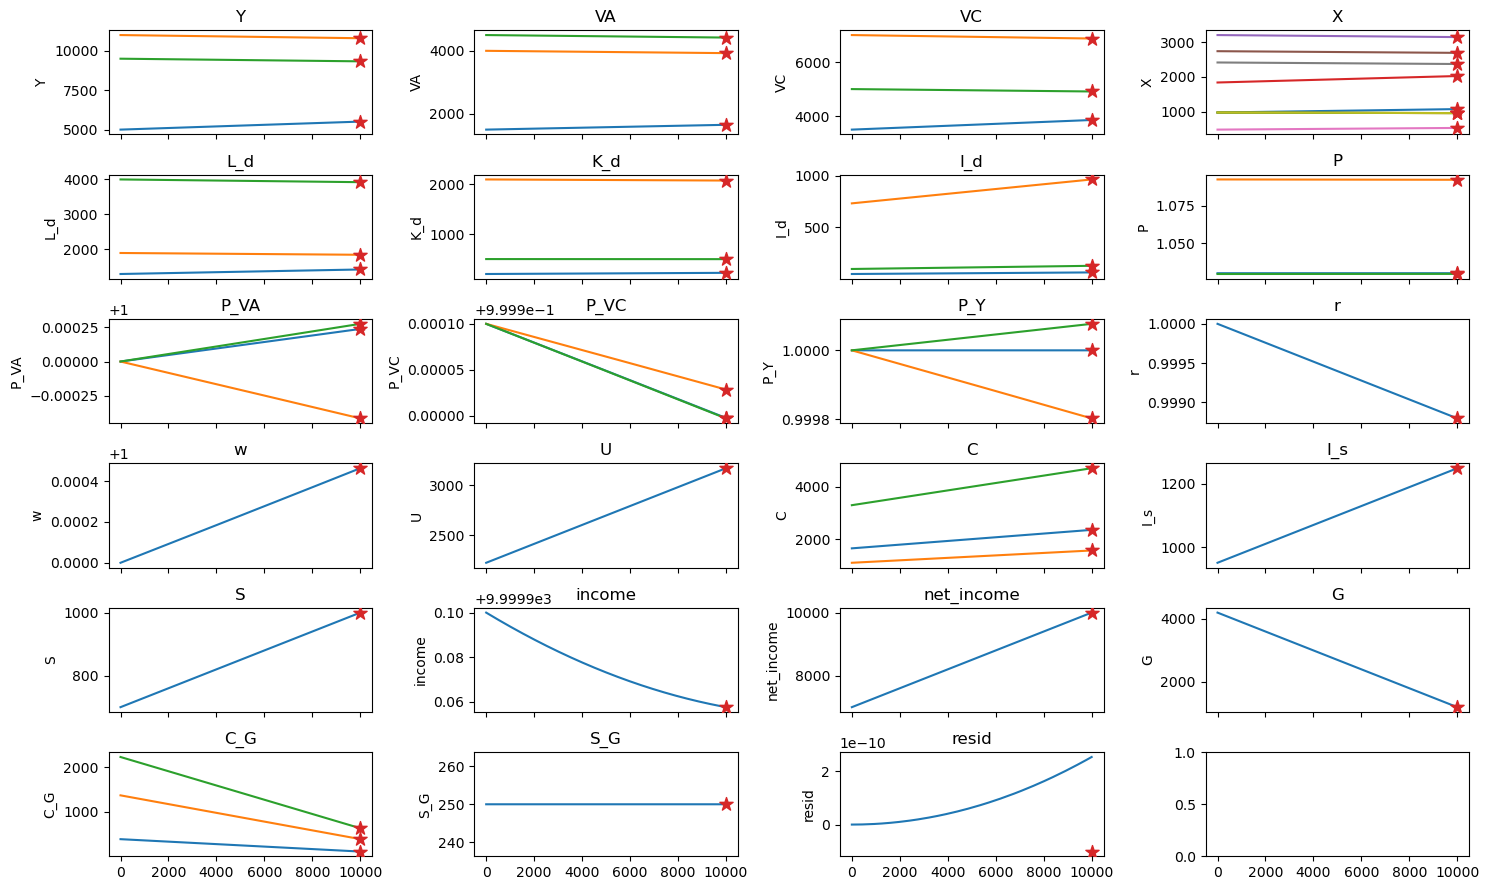

In [51]:
fig, ax = plt.subplots(6, 4, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()

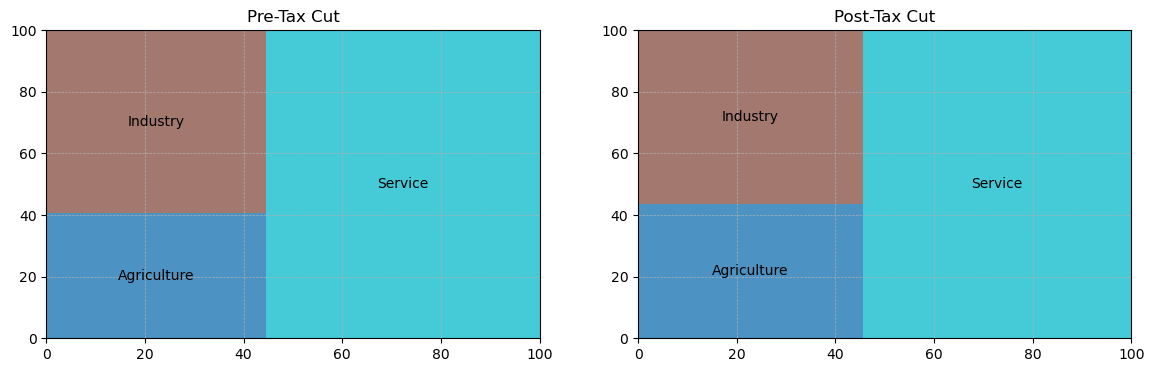

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Service"}

long_sectors = [short_to_long[x] for x in sectors]
cmap = plt.cm.tab10([0, 0.5, 1.0])

squarify.plot(sizes=calibrated_data["L_d"], label=long_sectors, alpha=0.8, ax=ax[0], color=cmap)
squarify.plot(sizes=res_d["L_d"], label=long_sectors, alpha=0.8, ax=ax[1], color=cmap)
for axis, title in zip(fig.axes, ["Pre-Tax Cut", "Post-Tax Cut"]):
    axis.grid(ls="--", lw=0.5)
    axis.set(title=title)

# Uncertainty

## Uncertainty in Simulations

In [54]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from cge_modeling.pytensorf.compile import compile_cge_model_to_pytensor_Op
from cge_modeling.pytensorf.optimize import root

coords = {"sector": sectors, "sector_bis": sectors}


def dims_to_nice_names(obj):
    convert_dict = {"i": "sector", "j": "sector_bis"}
    return tuple([convert_dict.get(dim, None) for dim in obj.dims])


with pm.Model(coords=coords):
    phi_VA_offset = pm.Gamma("phi_VA_offset", alpha=2, beta=0.1, dims=["sector"])
    phi_VA = pm.Deterministic("phi_VA", 3 + phi_VA_offset, dims=["sector"])
    input_dict = deepcopy(initial_data)
    input_dict["phi_VA"] = phi_VA

    calib_dict = calibrate_model(**input_dict, variables=mod.variables, parameters=mod.parameters)
    euler_op = mod._euler_approximation_Op(n_steps=1000)

    simulation_inputs = [calib_dict[x.name] for x in mod.variables + mod.parameters]
    simulation_inputs += [theta_tax_cut]

    simulation_results = euler_op(*simulation_inputs)
    for result, obj in zip(simulation_results, mod.variables):
        pm.Deterministic(obj.name, result[-1], dims=dims_to_nice_names(obj))

    idata = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"})

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x282A97840>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [phi_VA_offset]


array([[<Axes: title={'center': 'L_d\nAg'}>,
        <Axes: title={'center': 'L_d\nInd'}>,
        <Axes: title={'center': 'L_d\nServ'}>],
       [<Axes: title={'center': 'phi_VA\nAg'}>,
        <Axes: title={'center': 'phi_VA\nInd'}>,
        <Axes: title={'center': 'phi_VA\nServ'}>]], dtype=object)

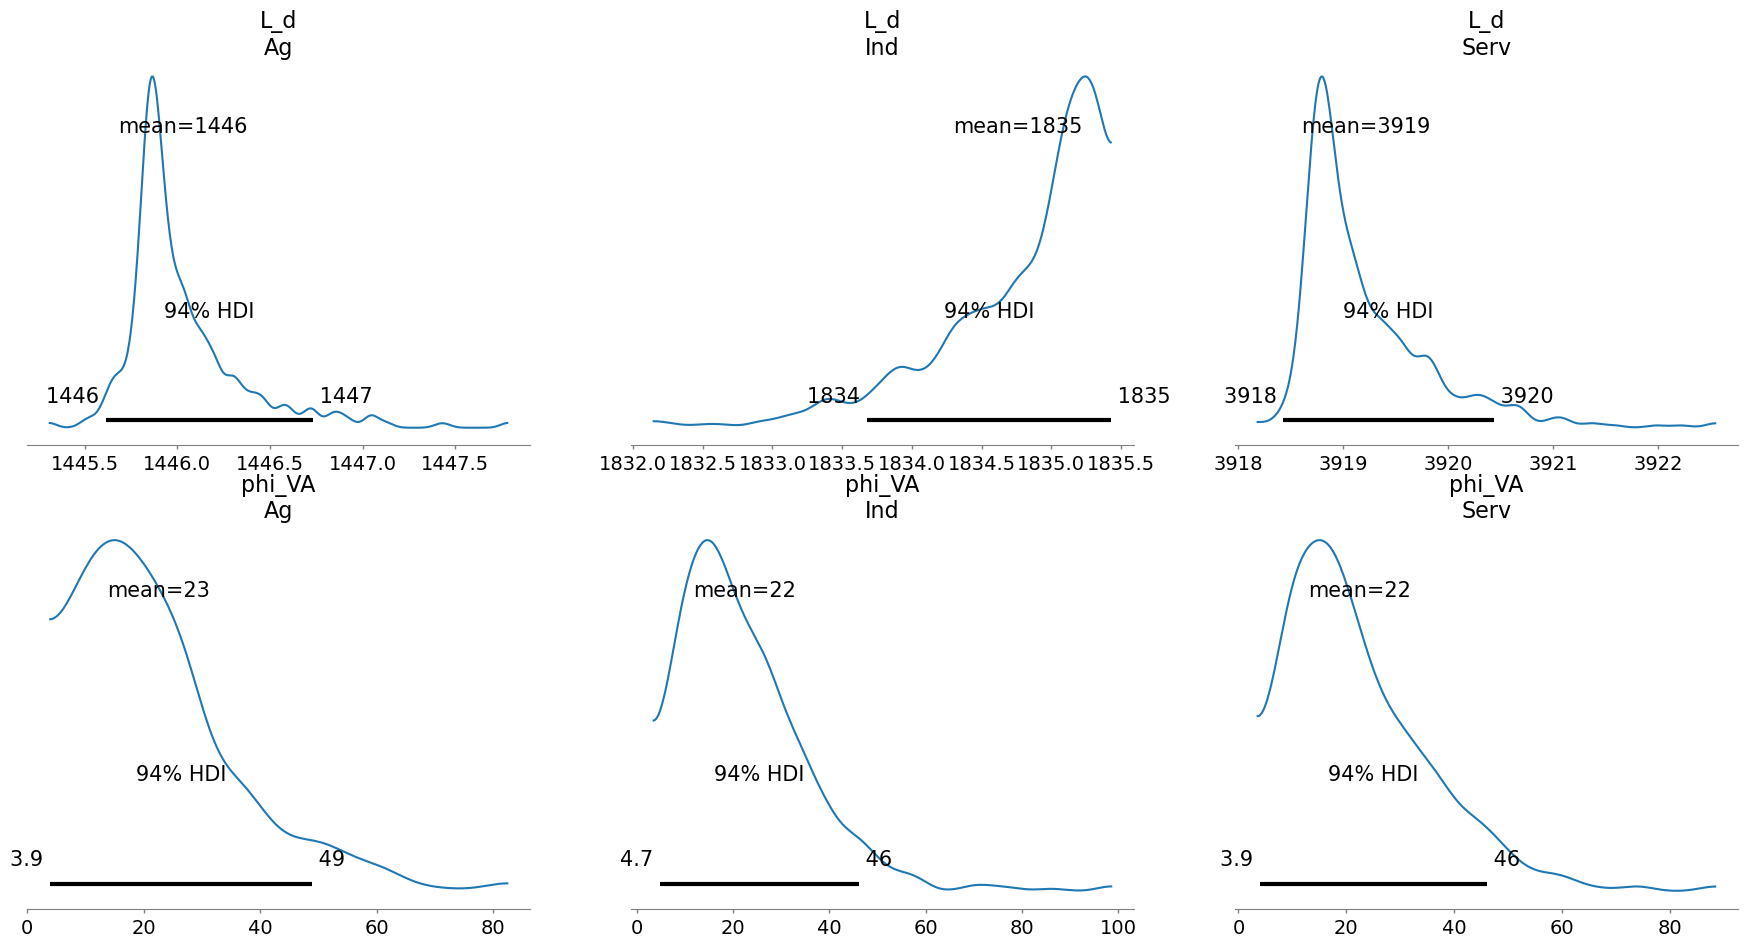

In [55]:
az.plot_posterior(idata.prior, var_names=["L_d", "phi_VA"])

## Missing Data Estimation

In [ ]:
with pm.Model(coords=coords) as m:
    f_model, f_jac, f_jac_inv = compile_cge_model_to_pytensor_Op(mod, inverse_method="solve")

    alpha = pm.Beta("alpha", 3, 3, dims=["sector"])
    alpha_k = pm.Dirchlet("alpha_k", a=[1, 1, 1], dims=["sector"])
    psi_VA = pm.Dirchlet("psi_VA", a=[1, 1, 1], dims=["sector"])
    psi_VC = pm.Dirchlet("psi_VC", a=[1, 1, 1], dims=["sector"])
    psi_X = pm.Dirchlet("psi_X", a=[1, 1, 1], dims=["sector", "sector_bis"])
    phi_VA_offset = pm.Gamma("phi_VA_offset", alpha=2, beta=0.1, dims=["sector"])
    phi_VA = pm.Deterministic("phi_VA", 3 + phi_VA_offset, dims=["sector"])

    tau = pm.Beta("tau", 1, 10, dims=["sector"])
    tau_income = pm.Beta("tau_income", 1, 10)
    gamma = pm.Dirchlet("gamma", a=[1, 1, 1], dims=["sector"])
    mps = pm.Beta("mps", 1, 5)
    alpha_G = pm.Dirchlet("alpha_G", a=[1, 1, 1], dims=["sector"])

    root_history, converged, step_size, n_steps = root(
        f_model, f_jac_inv, x0=x0, exog=params, tol=1e-8, max_iter=500
    )